In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn import neighbors, svm
from sklearn.compose import make_column_transformer

import utils
import statistics

import importlib
importlib.reload(utils)

<module 'utils' from '/Users/clement/OneDrive/School/ML/assignment1/utils.py'>

# Dataset

In [2]:
df = pd.read_csv("datasets/UCI_Credit_Card.csv", header=0)
df.shape

(30000, 25)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


(30000, 23)

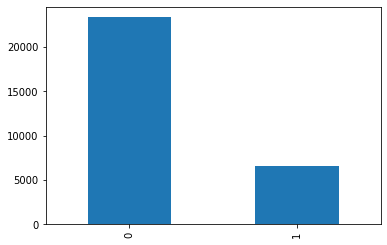

In [4]:
feature_cols = [col for col in df.columns if col != 'ID' and col != 'default.payment.next.month']
features = df[feature_cols]
target = df['default.payment.next.month']
target.value_counts().plot(kind="bar")
features.shape

In [22]:
col_names = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
scaled_cols = [x for x in list(features) if x not in col_names]

column_trans = make_column_transformer(
    (OneHotEncoder(), col_names),
    remainder=StandardScaler()
)

features_ohe = column_trans.fit_transform(features)
features_ohe.shape

(30000, 91)

In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_best = SelectKBest(mutual_info_classif, k=10).fit(features, target)
names = []
for importance, name in sorted(zip(k_best.scores_, features.columns),reverse=True):
    print (name, importance)
    names.append(name)

PAY_0 0.07604137959777901
PAY_2 0.04856280883744968
PAY_4 0.03482725071617865
PAY_3 0.03404041102796751
PAY_6 0.02821409915599893
PAY_5 0.027168939942321835
PAY_AMT1 0.020994383716675724
PAY_AMT3 0.018259278342403817
LIMIT_BAL 0.016806217936977674
PAY_AMT4 0.015446891968838194
PAY_AMT2 0.014544941394983857
PAY_AMT5 0.01422519972753733
PAY_AMT6 0.012450123904595545
BILL_AMT1 0.011515545297584584
BILL_AMT6 0.0070540290651366355
BILL_AMT3 0.006935047127001992
BILL_AMT5 0.006778582047773041
BILL_AMT2 0.006340616923049769
EDUCATION 0.0062117881771015515
MARRIAGE 0.0035468876072008992
BILL_AMT4 0.003348710382891751
SEX 0.0022529757846907472
AGE 0.0017148848737653655


In [20]:
top_features = features[['PAY_0', 'PAY_2', 'PAY_4', 'PAY_3', 'PAY_6', 'PAY_5', 'PAY_AMT1', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_AMT4']]
col_names = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
scaled_cols = [x for x in list(top_features) if x not in col_names]

column_trans = make_column_transformer(
    (OneHotEncoder(), col_names),
    remainder=StandardScaler()
)

top_features_ohe = column_trans.fit_transform(top_features)
top_features_ohe.shape

(30000, 68)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=5)
x_train_e, x_test_e, y_train_e, y_test_e = train_test_split(features_ohe, target, test_size=0.2, stratify=target, random_state=5)

In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(unique_elements, counts_elements)
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(unique_elements, counts_elements)

[0 1] [18691  5309]
[0 1] [4673 1327]


# Baseline

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(x_train, y_train)
pred = dummy_clf.predict(x_test)
print(classification_report(y_test, pred))

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
pred = dummy_clf.predict(x_test)
print(classification_report(y_test, pred, digits=4))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61      4673
           1       0.22      0.49      0.30      1327

    accuracy                           0.50      6000
   macro avg       0.50      0.50      0.45      6000
weighted avg       0.65      0.50      0.54      6000

              precision    recall  f1-score   support

           0     0.7788    1.0000    0.8757      4673
           1     0.0000    0.0000    0.0000      1327

    accuracy                         0.7788      6000
   macro avg     0.3894    0.5000    0.4378      6000
weighted avg     0.6066    0.7788    0.6820      6000



/home/clement/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [7]:
base_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
scores = cross_val_score(decision_tree_cf, x_train, y_train, cv=5, scoring='f1_macro')
print(statistics.mean(scores))

0.6128244868607682


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed:    3.0s remaining:   36.9s
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed:    4.8s remaining:   22.2s
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed:    6.0s remaining:   15.3s
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed:    8.0s remaining:   12.7s
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed:    9.0s remaining:    9.4s
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed:   10.7s remaining:    7.4s
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed:   13.4s remaining:    3.4s
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed:   14.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:   15.8s finished


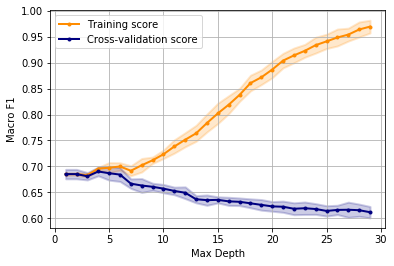

In [9]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(decision_tree_cf, x_train, y_train, param_name="max_depth", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Max Depth")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of 500 | elapsed:   10.5s remaining:  1.9min
[Parallel(n_jobs=8)]: Done  93 out of 500 | elapsed:   16.2s remaining:  1.2min
[Parallel(n_jobs=8)]: Done 144 out of 500 | elapsed:   21.5s remaining:   53.2s
[Parallel(n_jobs=8)]: Done 195 out of 500 | elapsed:   27.2s remaining:   42.6s
[Parallel(n_jobs=8)]: Done 246 out of 500 | elapsed:   32.3s remaining:   33.3s
[Parallel(n_jobs=8)]: Done 297 out of 500 | elapsed:   37.6s remaining:   25.7s
[Parallel(n_jobs=8)]: Done 348 out of 500 | elapsed:   42.5s remaining:   18.5s
[Parallel(n_jobs=8)]: Done 399 out of 500 | elapsed:   47.6s remaining:   12.1s
[Parallel(n_jobs=8)]: Done 450 out of 500 | elapsed:   52.5s remaining:    5.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   57.4s finished


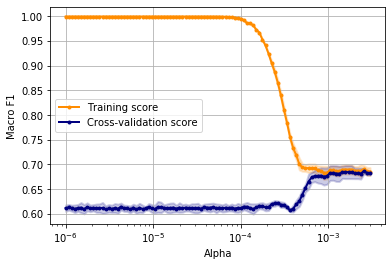

In [8]:
param_range = np.geomspace(0.000001, 0.003, 100, endpoint=True)
train_scores, test_scores = validation_curve(decision_tree_cf, x_train, y_train, param_name="ccp_alpha", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Alpha", log=True)

In [77]:
params = [{'ccp_alpha': np.linspace(0.0005, 0.002, 20, endpoint=True), 'max_depth': range(1, 8)}]
grid_cv = GridSearchCV(decision_tree_cf, params, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
grid_cv.fit(x_train, y_train)
res = grid_cv.cv_results_

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(

In [78]:
decision_tree_cf = grid_cv.best_estimator_
print (grid_cv.best_score_, grid_cv.best_params_)

0.6902299616673246 {'ccp_alpha': 0.0007368421052631579, 'max_depth': 4}


In [92]:
decision_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', ccp_alpha=0.0007368421052631579, max_depth=4)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    1.8s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:    1.9s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:    1.9s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:    2.0s remaining:    2.5s
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    2.2s finished


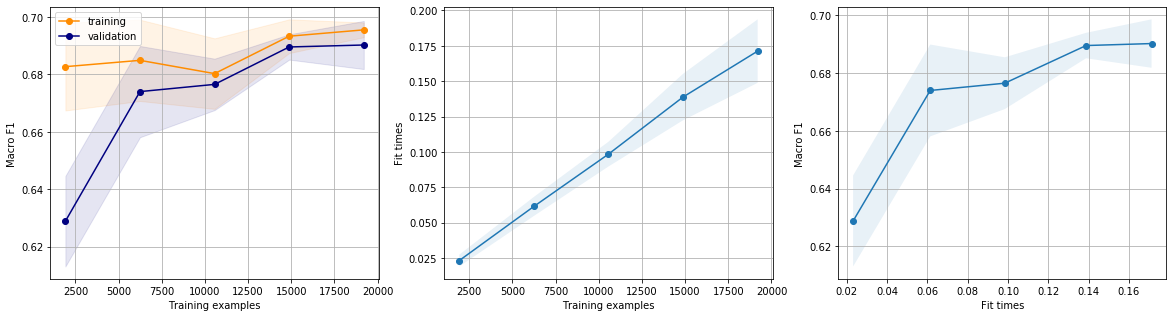

In [93]:
title = ''
utils.plot_learning_curve(decision_tree_cf, title, x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [94]:
decision_tree_cf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0007368421052631579, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [95]:
tree_pred = decision_tree_cf.predict(x_test)
print(confusion_matrix(y_test, tree_pred))
print(classification_report(y_test, tree_pred, digits=4))

[[3794  879]
 [ 552  775]]
              precision    recall  f1-score   support

         0.0     0.8730    0.8119    0.8413      4673
         1.0     0.4686    0.5840    0.5200      1327

    accuracy                         0.7615      6000
   macro avg     0.6708    0.6980    0.6806      6000
weighted avg     0.7835    0.7615    0.7703      6000



In [96]:
for importance, name in sorted(zip(decision_tree_cf.feature_importances_, features.columns),reverse=True):
    print (name, importance)

PAY_0 0.793240813342977
PAY_AMT2 0.06986864254113756
PAY_4 0.041797933931560304
PAY_2 0.038342748570502544
PAY_3 0.019555907089285573
LIMIT_BAL 0.017652753331174727
PAY_AMT3 0.013897032206586956
PAY_6 0.005644168986775255
SEX 0.0
PAY_AMT6 0.0
PAY_AMT5 0.0
PAY_AMT4 0.0
PAY_AMT1 0.0
PAY_5 0.0
MARRIAGE 0.0
EDUCATION 0.0
BILL_AMT6 0.0
BILL_AMT5 0.0
BILL_AMT4 0.0
BILL_AMT3 0.0
BILL_AMT2 0.0
BILL_AMT1 0.0
AGE 0.0


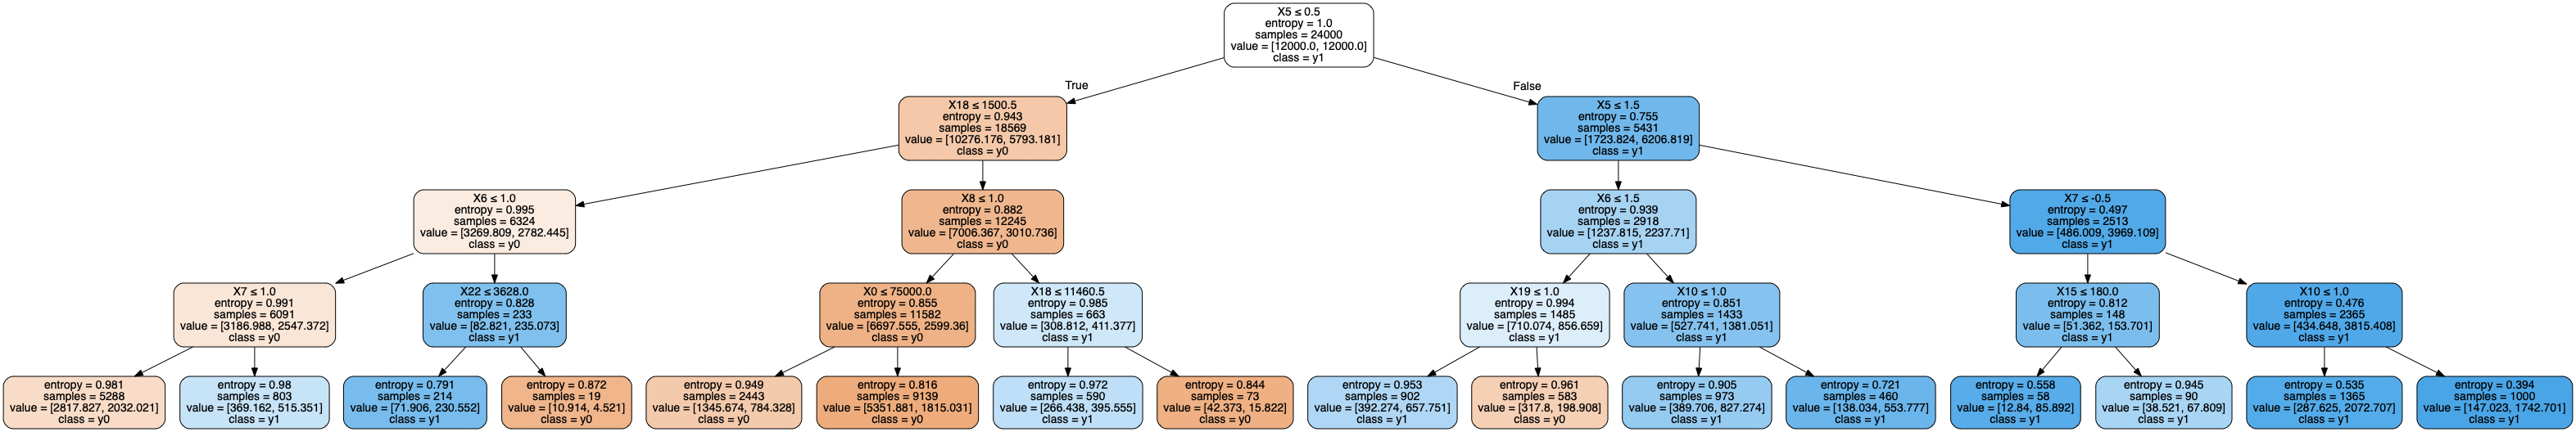

In [91]:
# Decision Tree visualizer code credit to this SO post:
# https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(decision_tree_cf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

# Neural Network

In [18]:
nn_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 64 ,64), batch_size=50)
scores = cross_val_score(nn_clf, x_train_e, y_train_e.values.ravel(), cv=5, scoring='f1_macro')
print(statistics.mean(scores))

0.6812696842462052


[1.00000000e-05 1.62377674e-05 2.63665090e-05 4.28133240e-05
 6.95192796e-05 1.12883789e-04 1.83298071e-04 2.97635144e-04
 4.83293024e-04 7.84759970e-04 1.27427499e-03 2.06913808e-03
 3.35981829e-03 5.45559478e-03 8.85866790e-03 1.43844989e-02
 2.33572147e-02 3.79269019e-02 6.15848211e-02 1.00000000e-01]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of 100 | elapsed:    6.7s remaining:  5.5min
[Parallel(n_jobs=8)]: Done  13 out of 100 | elapsed:   16.4s remaining:  1.8min
[Parallel(n_jobs=8)]: Done  24 out of 100 | elapsed:   27.8s remaining:  1.5min
[Parallel(n_jobs=8)]: Done  35 out of 100 | elapsed:   34.9s remaining:  1.1min
[Parallel(n_jobs=8)]: Done  46 out of 100 | elapsed:   45.7s remaining:   53.6s
[Parallel(n_jobs=8)]: Done  57 out of 100 | elapsed:   52.5s remaining:   39.6s
[Parallel(n_jobs=8)]: Done  68 out of 100 | elapsed:  1.0min remaining:   29.2s
[Parallel(n_jobs=8)]: Done  79 out of 100 | elapsed:  1.1min remaining:   18.2s
[Parallel(n_jobs=8)]: Done  90 out of 100 | elapsed:  1.4min remaining:    9.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished


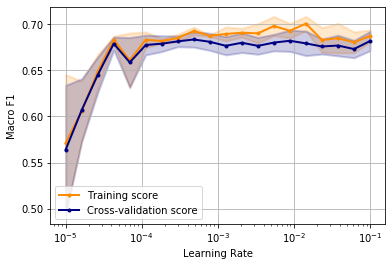

In [83]:
param_range = np.geomspace(0.00001, 0.1, 20, endpoint=True)
train_scores, test_scores = validation_curve(nn_clf, x_train_e, y_train_e.values.ravel(), param_name="learning_rate_init", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Learning Rate", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of 100 | elapsed:    5.4s remaining:  4.4min
[Parallel(n_jobs=8)]: Done  13 out of 100 | elapsed:   12.9s remaining:  1.4min
[Parallel(n_jobs=8)]: Done  24 out of 100 | elapsed:   19.3s remaining:  1.0min
[Parallel(n_jobs=8)]: Done  35 out of 100 | elapsed:   26.8s remaining:   49.8s
[Parallel(n_jobs=8)]: Done  46 out of 100 | elapsed:   33.2s remaining:   39.0s
[Parallel(n_jobs=8)]: Done  57 out of 100 | elapsed:   38.0s remaining:   28.6s
[Parallel(n_jobs=8)]: Done  68 out of 100 | elapsed:   44.8s remaining:   21.1s
[Parallel(n_jobs=8)]: Done  79 out of 100 | elapsed:   52.2s remaining:   13.9s
[Parallel(n_jobs=8)]: Done  90 out of 100 | elapsed:   57.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished


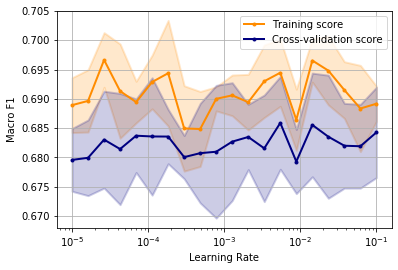

In [110]:
param_range = np.geomspace(0.00001, 0.1, 20, endpoint=True)
train_scores, test_scores = validation_curve(nn_clf, x_train_e, y_train_e.values.ravel(), param_name="alpha", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Learning Rate", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    3.1s remaining:   35.4s
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:    5.1s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:    6.7s remaining:   14.3s
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:    8.6s remaining:   11.0s
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:   10.4s remaining:    8.2s
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:   14.6s remaining:    6.9s
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:   16.2s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:   18.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   19.4s finished


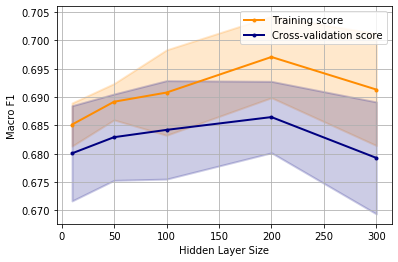

In [85]:
param_range = [(10), (50), (100), (200), (300)]
train_scores, test_scores = validation_curve(nn_clf, x_train_e, y_train_e.values.ravel(), param_name="hidden_layer_sizes", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Hidden Layer Size")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:    3.2s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    3.8s remaining:   10.3s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    4.4s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    5.8s remaining:    5.1s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:    6.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    7.8s remaining:    1.9s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    8.9s finished


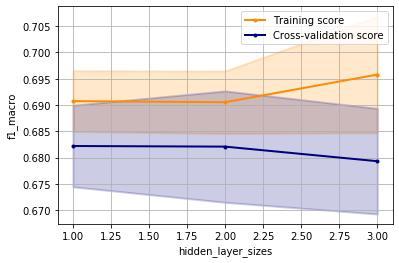

In [92]:
param_range = [(50), (50, 50), (50, 50, 50)]
train_scores, test_scores = validation_curve(nn_clf, x_train_e, y_train_e.values.ravel(), param_name="hidden_layer_sizes", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.xlabel('hidden_layer_sizes')
plt.ylabel('f1_macro')
lw = 2
param_range = [1,2,3]
plt.plot(param_range, train_scores_mean, '.-', label="Training score",
            color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
            color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  30 | elapsed:    9.3s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   7 out of  30 | elapsed:   14.4s remaining:   47.3s
[Parallel(n_jobs=8)]: Done  11 out of  30 | elapsed:   26.4s remaining:   45.7s
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed:   31.7s remaining:   31.7s
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed:   35.9s remaining:   20.8s
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed:   43.9s remaining:   13.4s
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed:   52.4s remaining:    5.8s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  1.2min finished


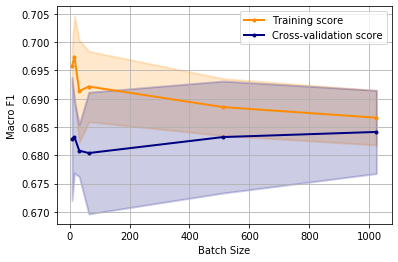

In [87]:
param_range = [8, 16, 32, 64, 512, 1024]
train_scores, test_scores = validation_curve(nn_clf, x_train_e, y_train_e.values.ravel(), param_name="batch_size", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Batch Size")

In [86]:
tuned_parameters = [{'batch_size': [512, 1024], 'solver': ['adam'], 
                     'hidden_layer_sizes': [(10), (20), (30), (40), (50), (100), (200)], 
                     'learning_rate_init': [0.0001, 0.001, 0.01],
                     'alpha': [0.0001, 0.001, 0.01, 0.1]}]
                     
nn_grid_cv = GridSearchCV(nn_clf, tuned_parameters, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
nn_grid_cv.fit(x_train_e, y_train_e.values.ravel())
nn_res = nn_grid_cv.cv_results_

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   22.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   27.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   35.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   46.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(

In [87]:
nn_clf = nn_grid_cv.best_estimator_
print (nn_grid_cv.best_score_, nn_grid_cv.best_params_)

0.6879878999170839 {'alpha': 0.001, 'batch_size': 1024, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01, 'solver': 'adam'}


In [14]:
nn_clf = MLPClassifier(early_stopping=True, alpha=0.01, batch_size=1024, hidden_layer_sizes=(20), learning_rate_init=0.01)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    4.7s remaining:   53.5s
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:    5.4s remaining:   21.8s
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:    6.3s remaining:   13.3s
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:    6.7s remaining:    8.6s
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:    7.0s remaining:    5.5s
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:    7.3s remaining:    3.4s
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:    7.9s remaining:    2.0s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:    8.1s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    8.6s finished


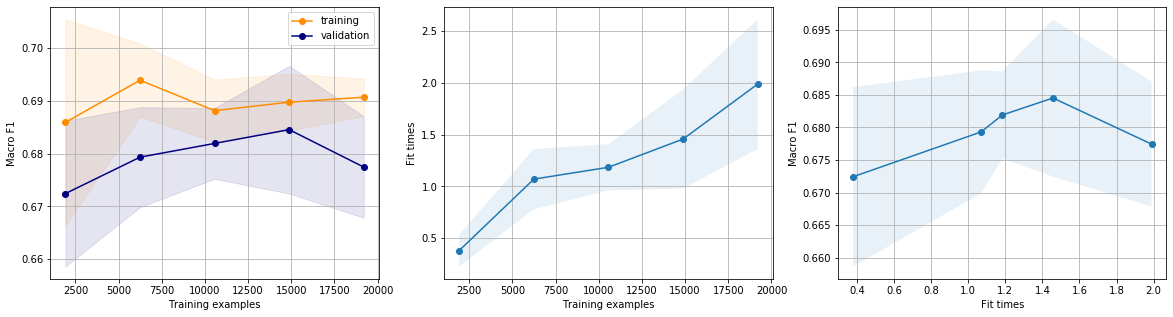

In [26]:
title = ''
utils.plot_learning_curve(nn_clf, title, x_train_e, y_train_e.values.ravel(), scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [15]:
nn_clf.fit(x_train_e, y_train_e.values.ravel())

MLPClassifier(activation='relu', alpha=0.01, batch_size=1024, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=20, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

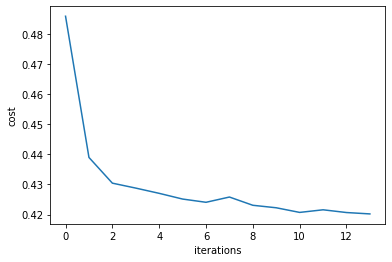

In [21]:
plt.ylabel('cost')
plt.xlabel('iterations')
plt.plot(nn_clf.loss_curve_)
plt.show()

In [22]:
nn_pred = nn_clf.predict(x_test_e)
print(confusion_matrix(y_test_e, nn_pred))
print(classification_report(y_test_e, nn_pred, digits=4))

[[4414  259]
 [ 839  488]]
              precision    recall  f1-score   support

           0     0.8403    0.9446    0.8894      4673
           1     0.6533    0.3677    0.4706      1327

    accuracy                         0.8170      6000
   macro avg     0.7468    0.6562    0.6800      6000
weighted avg     0.7989    0.8170    0.7968      6000



# KNN

In [16]:
knn_clf = neighbors.KNeighborsClassifier(n_jobs=8)
scores = cross_val_score(knn_clf, x_train_e, y_train_e.values.ravel(), cv=5, scoring='f1_macro')
print(statistics.mean(scores))

0.6481005865640869


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed:  2.4min remaining: 29.1min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed:  4.8min remaining: 21.8min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed:  7.2min remaining: 18.3min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed: 10.1min remaining: 16.1min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed: 13.0min remaining: 13.5min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed: 16.1min remaining: 11.0min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed: 18.8min remaining:  8.2min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed: 21.3min remaining:  5.3min
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed: 23.9min remaining:  2.5min
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed: 26.2min finished


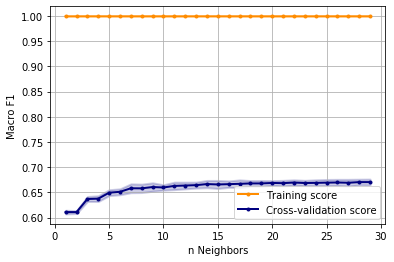

In [38]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(neighbors.KNeighborsClassifier(weights='distance', p=1), x_train_e, y_train_e.values.ravel(), param_name="n_neighbors", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "n Neighbors")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed:  2.2min remaining: 27.2min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed:  4.5min remaining: 20.7min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed:  6.8min remaining: 17.3min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed:  9.7min remaining: 15.3min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed: 12.6min remaining: 13.1min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed: 15.6min remaining: 10.7min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed: 18.2min remaining:  7.9min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed: 21.0min remaining:  5.2min
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed: 23.5min remaining:  2.5min
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed: 25.8min finished


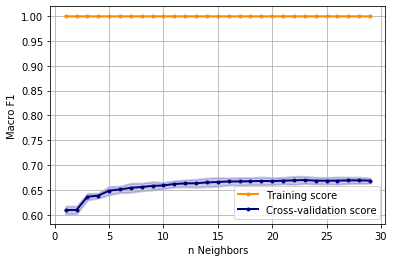

In [39]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(neighbors.KNeighborsClassifier(weights='distance', p=2), x_train_e, y_train_e.values.ravel(), param_name="n_neighbors", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "n Neighbors")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed:  2.3min remaining: 28.3min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed:  4.6min remaining: 21.2min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed:  6.9min remaining: 17.6min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed:  9.6min remaining: 15.3min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed: 12.5min remaining: 13.0min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed: 15.5min remaining: 10.7min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed: 18.0min remaining:  7.8min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed: 20.6min remaining:  5.2min
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed: 23.2min remaining:  2.5min
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed: 25.9min finished


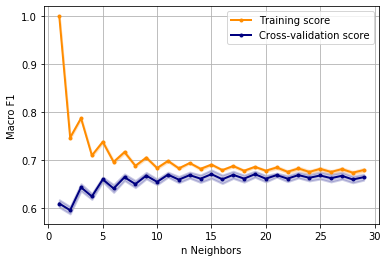

In [40]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(neighbors.KNeighborsClassifier(weights='uniform', p=2), x_train_e, y_train_e.values.ravel(), param_name="n_neighbors", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "n Neighbors")

In [41]:
# Credit to sklearn tutorial on KNN classification:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
tuned_parameters = [{'n_neighbors': range(15, 30), 'weights': ['uniform'], 'p': [1, 2]}]
                     
knn_grid_cv = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
knn_grid_cv.fit(x_train_e, y_train_e.values.ravel())
knn_res = knn_grid_cv.cv_results_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 17.0min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 20.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 23.5min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 27.2min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 32.2min finished


In [42]:
knn_clf = knn_grid_cv.best_estimator_
print (knn_grid_cv.best_score_, knn_grid_cv.best_params_)

0.6712478516128151 {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}


In [23]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=19, weights='uniform', p=1, n_jobs=8)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:   11.2s remaining:  2.1min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:   32.5s remaining:  2.2min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:   57.0s remaining:  2.0min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  1.4min remaining:  1.8min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  1.7min remaining:  1.3min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  2.6min remaining:  1.2min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:  2.8min remaining:   42.4s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  3.2min remaining:   16.7s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  3.9min finished


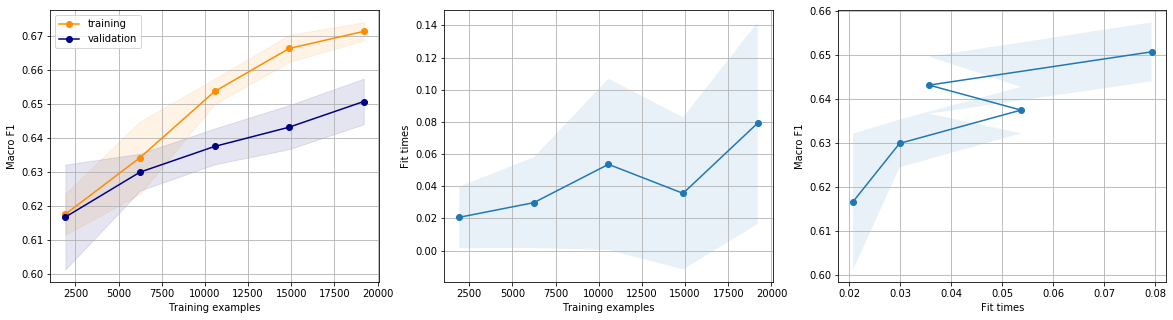

In [27]:
title = ''
utils.plot_learning_curve(knn_clf, title, x_train_e, y_train_e.values.ravel(), cv=5, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [24]:
knn_clf.fit(x_train_e, y_train_e.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=19, p=1,
                     weights='uniform')

In [25]:
knn_pred = knn_clf.predict(x_test_e)
print(confusion_matrix(y_test_e, knn_pred))
print(classification_report(y_test_e, knn_pred, digits=4))

[[4438  235]
 [ 938  389]]
              precision    recall  f1-score   support

           0     0.8255    0.9497    0.8833      4673
           1     0.6234    0.2931    0.3988      1327

    accuracy                         0.8045      6000
   macro avg     0.7245    0.6214    0.6410      6000
weighted avg     0.7808    0.8045    0.7761      6000



# SVM

In [74]:
svm_clf = svm.SVC(class_weight='balanced', kernel='rbf')
scores = cross_val_score(svm_clf, x_train_e, y_train_e.values.ravel(), cv=5, n_jobs=8, verbose=10, scoring='f1_macro')
print(statistics.mean(scores))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:  1.1min remaining:   45.6s


0.6948941290803015


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.1min finished


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed:  2.4min remaining: 37.5min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed:  4.3min remaining: 19.6min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed:  5.3min remaining: 12.4min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed:  7.8min remaining: 10.8min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed:  9.6min remaining:  8.2min
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed: 11.6min remaining:  6.0min
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed: 13.1min remaining:  3.7min
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed: 14.6min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 17.2min finished


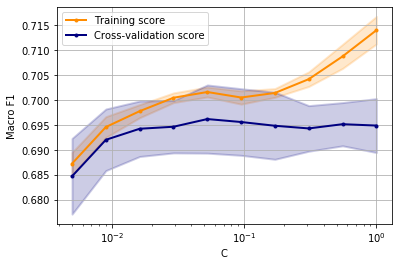

In [75]:
param_range = np.geomspace(0.005, 1.0, 10)
train_scores, test_scores = validation_curve(svm_clf, x_train_e, y_train_e.values.ravel(), param_name="C", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "C", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed:  2.5min remaining: 39.7min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed:  5.8min remaining: 26.3min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed: 10.5min remaining: 24.6min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed: 15.3min remaining: 21.1min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed: 25.1min remaining: 21.4min
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed: 35.3min remaining: 18.2min
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed: 41.3min remaining: 11.7min
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed: 66.8min remaining:  7.4min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 175.2min finished


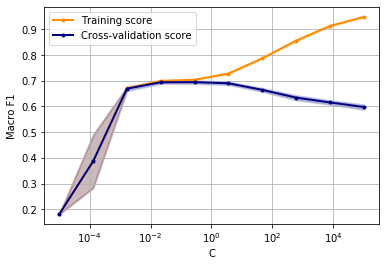

In [78]:
param_range = np.geomspace(10**-5, 10**5, 10)
train_scores, test_scores = validation_curve(svm_clf, x_train_e, y_train_e.values.ravel(), param_name="C", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "C", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  20 | elapsed:  4.8min remaining: 27.3min
[Parallel(n_jobs=8)]: Done   6 out of  20 | elapsed:  5.6min remaining: 13.1min
[Parallel(n_jobs=8)]: Done   9 out of  20 | elapsed:  8.5min remaining: 10.4min
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed: 10.3min remaining:  6.8min
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed: 11.3min remaining:  3.8min
[Parallel(n_jobs=8)]: Done  18 out of  20 | elapsed: 14.1min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed: 15.6min finished


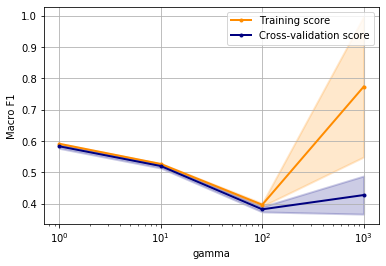

In [69]:
param_range = [1, 10, 100, 1000]
train_scores, test_scores = validation_curve(svm.SVC(class_weight='balanced', kernel='rbf', C=0.07), x_train_e, y_train_e.values.ravel(), param_name="gamma", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "gamma", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  20 | elapsed:  3.6min remaining: 20.1min
[Parallel(n_jobs=8)]: Done   6 out of  20 | elapsed:  3.6min remaining:  8.4min
[Parallel(n_jobs=8)]: Done   9 out of  20 | elapsed:  6.5min remaining:  7.9min
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  6.9min remaining:  4.6min
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:  7.2min remaining:  2.4min
[Parallel(n_jobs=8)]: Done  18 out of  20 | elapsed:  9.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed: 10.0min finished


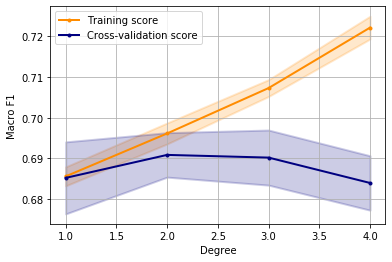

In [51]:
param_range = range(1, 5)
train_scores, test_scores = validation_curve(svm.SVC(class_weight='balanced', kernel='poly'), x_train_e, y_train_e.values.ravel(), param_name="degree", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Degree")

In [80]:
# Credit to sklearn svm tuturial: 
# https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
c_range = np.geomspace(0.05, 0.1, 5)
d_range = [1, 2, 3]
tuned_parameters = [{'kernel': ['rbf'], 'C': np.geomspace(10**-4, 10**4, 10), 'gamma': np.geomspace(10**-4, 10**4, 10)}]
                    #{'kernel': ['poly'], 'C': c_range, 'degree': d_range}]
                     
svm_grid_cv = GridSearchCV(svm.SVC(class_weight='balanced'), tuned_parameters, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
svm_grid_cv.fit(x_train_e, y_train_e.values.ravel())
svm_res = svm_grid_cv.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 16.8min


KeyboardInterrupt: 

In [81]:
svm_clf = svm_grid_cv.best_estimator_
print (svm_grid_cv.best_score_, svm_grid_cv.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [28]:
svm_clf = svm.SVC(class_weight='balanced', kernel='rbf', C=0.071)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    7.7s remaining:  1.5min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:   29.8s remaining:  2.0min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:  1.3min remaining:  2.8min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  1.7min remaining:  2.2min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  3.0min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:  3.9min remaining:   58.5s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  5.1min remaining:   26.4s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  7.2min finished


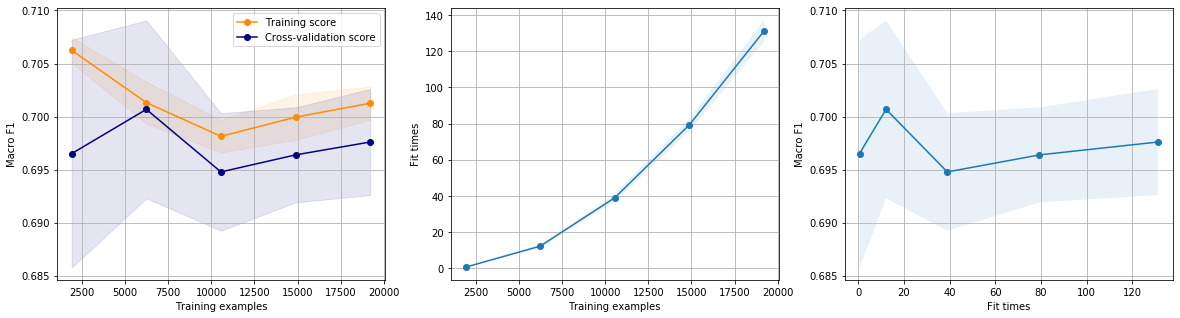

In [63]:
title = ''
utils.plot_learning_curve(svm_clf, title, x_train_e, y_train_e, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [29]:
svm_clf.fit(x_train_e, y_train_e.values.ravel())

SVC(C=0.071, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [30]:
svm_pred = svm_clf.predict(x_test_e)
print(confusion_matrix(y_test_e, svm_pred))
print(classification_report(y_test_e, svm_pred, digits=4))

[[3979  694]
 [ 608  719]]
              precision    recall  f1-score   support

           0     0.8675    0.8515    0.8594      4673
           1     0.5088    0.5418    0.5248      1327

    accuracy                         0.7830      6000
   macro avg     0.6881    0.6967    0.6921      6000
weighted avg     0.7881    0.7830    0.7854      6000



# Boosting

In [101]:
base_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', ccp_alpha=0.0007368421052631579, max_depth=4)
ada_clf = AdaBoostClassifier(base_estimator=base_tree_cf, random_state=1, learning_rate=0.01)
scores = cross_val_score(ada_clf, x_train, y_train, cv=5, n_jobs=8, verbose=10, scoring='f1_macro')
print(statistics.mean(scores))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.6927422525940575


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    6.4s finished


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  35 | elapsed:   19.0s remaining:  2.5min
[Parallel(n_jobs=8)]: Done   8 out of  35 | elapsed:   55.6s remaining:  3.1min
[Parallel(n_jobs=8)]: Done  12 out of  35 | elapsed:  1.5min remaining:  2.9min
[Parallel(n_jobs=8)]: Done  16 out of  35 | elapsed:  2.1min remaining:  2.5min
[Parallel(n_jobs=8)]: Done  20 out of  35 | elapsed:  2.7min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  24 out of  35 | elapsed:  3.1min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed:  3.7min remaining:   55.3s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:  4.4min remaining:   24.9s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:  5.6min finished


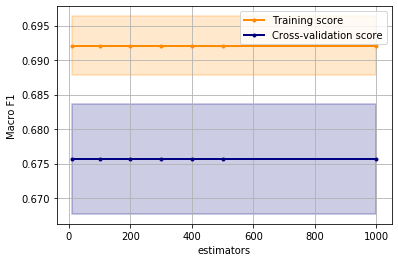

In [16]:
param_range = [10, 100, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(
    ada_clf, x_train, y_train, param_name='n_estimators', param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "estimators")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed:   12.0s remaining:  3.1min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed:   30.5s remaining:  2.3min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed:  1.1min remaining:  2.7min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed:  2.2min remaining:  3.1min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed:  3.4min remaining:  2.9min
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed:  5.0min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed:  5.7min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed:  7.3min remaining:   48.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  9.7min finished


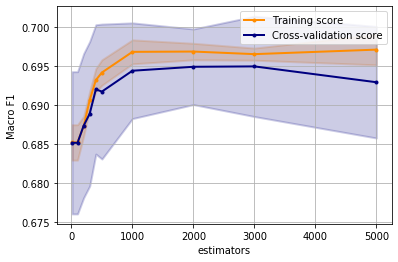

In [105]:
param_range = [10, 100, 200, 300, 400, 500, 1000, 2000, 3000, 5000]
train_scores, test_scores = validation_curve(
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=1), 
        learning_rate=0.01
    ), x_train, y_train, param_name='n_estimators', param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "estimators")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  35 | elapsed:  1.4min remaining: 10.9min
[Parallel(n_jobs=8)]: Done   8 out of  35 | elapsed:  4.2min remaining: 14.0min
[Parallel(n_jobs=8)]: Done  12 out of  35 | elapsed:  6.4min remaining: 12.4min
[Parallel(n_jobs=8)]: Done  16 out of  35 | elapsed:  9.0min remaining: 10.7min
[Parallel(n_jobs=8)]: Done  20 out of  35 | elapsed: 11.7min remaining:  8.8min
[Parallel(n_jobs=8)]: Done  24 out of  35 | elapsed: 13.4min remaining:  6.1min
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed: 15.8min remaining:  4.0min
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed: 19.0min remaining:  1.8min
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed: 23.6min finished


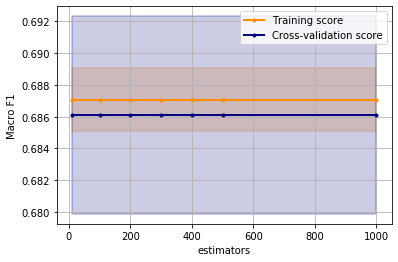

In [69]:
param_range = [10, 100, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy', ccp_alpha=0.01)), x_train, y_train, param_name='n_estimators', param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "estimators")

In [106]:
params = [{'base_estimator': [
                DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=1)
            ],
           'n_estimators': [1000, 2000, 3000], 
           'learning_rate': np.geomspace(0.0001, 1.0, 10)}]
boost_grid_cv = GridSearchCV(AdaBoostClassifier(decision_tree_cf, random_state=1), params, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
boost_grid_cv.fit(x_train, y_train)
boost_res = boost_grid_cv.cv_results_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 13.0min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 16.5min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 19.8min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 23.3min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 27.7min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 31.0min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 36.5min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 42.0min finished


In [107]:
boost_clf = boost_grid_cv.best_estimator_
print (boost_grid_cv.best_score_, boost_grid_cv.best_params_)

0.6954765088405072 {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=1, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best'), 'learning_rate': 0.005994842503189409, 'n_estimators': 2000}


In [108]:
boost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='entropy', max_depth=1),
                              n_estimators=2000, learning_rate=0.006)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:   18.4s remaining:  3.5min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:  1.1min remaining:  4.3min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:  1.6min remaining:  3.3min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  2.0min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  2.5min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  3.0min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:  3.5min remaining:   51.9s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  4.0min remaining:   21.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  4.5min finished


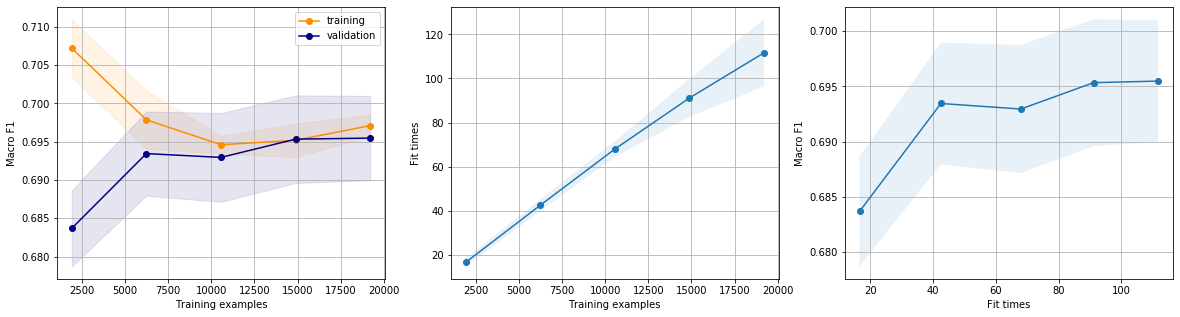

In [109]:
title = ''
utils.plot_learning_curve(boost_clf, title, x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [110]:
boost_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                 

In [111]:
boost_pred = boost_clf.predict(x_test)
print(confusion_matrix(y_test, boost_pred))
print(classification_report(y_test, boost_pred, digits=4))

[[3906  767]
 [ 574  753]]
              precision    recall  f1-score   support

         0.0     0.8719    0.8359    0.8535      4673
         1.0     0.4954    0.5674    0.5290      1327

    accuracy                         0.7765      6000
   macro avg     0.6836    0.7017    0.6912      6000
weighted avg     0.7886    0.7765    0.7817      6000

